## SENTINEL Hub data access using xcube

This notebook shows the various ways to open data cubes from Sentinel Hub (SH) for a given time range, region, and spatial resolution:

1. A **temporarily regular Sentinel-2 cube** with aggregated observations that fall into equal-size time periods;
2. A **temporarily irregular Sentinel-2 cube** which only includes time stamps where there were valid observations;
3. A cube using **projected coordinates**.


To run this Notebook, make sure the SENTINEL Hub / xcube Integration is setup correctly, see [Ex0-DCFS-Setup](./Ex0-DCFS-Setup.ipynb).

In [1]:
# xcube_sh imports
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers
from xcube_sh.viewer import ViewerServer

# xcube imports
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry

# Various utilities
import json
import xarray as xr
import shapely.geometry
import IPython.display
import zarr

In [2]:
%matplotlib inline

---
For this demo, we are focussing on small coastal area near Kiel in Northern Germany (Baltic Sea)

In [3]:
x1 = 10.00  # degree
y1 = 54.27  # degree
x2 = 11.00  # degree
y2 = 54.60  # degree

bbox = x1, y1, x2, y2

Visualize the bounding box. If you don't see anything, please refer to [Ex0-DCFS-Setup](./Ex0-DCFS-Setup.ipynb).

In [4]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Later in this NB we are going to compute some indexes from bands atmospherically corrected bands B04, B05, B06, B11 of Sentinel-2 (S2L2A)
Our time range covers two and a half month of last year's summer: 2018-05-14 to 2018-07-31

The desired resolution is roughly 20 meters per pixel:

In [5]:
spatial_res = 0.00018   # = 20.038 meters in degree>

---
Example (2): Sentinel-2 L2A with aggregated observations that fall into equal-size `time_period` of 2 days:

In [6]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'B05', 'B06', 'B11', 'SCL', 'CLD'],
                         tile_size=[512, 512],
                         geometry=bbox,
                         spatial_res=spatial_res,
                         time_range=['2018-05-14', '2018-07-31'],
                         time_period='2D')

We define a `request_collector` as an observer for SH requests made, so we can show SH usage stats. This is a developer tool, useful for demonstration purposes too. **Otherwise, this is not needed.**

In [7]:
request_collector = Observers.request_collector()

Open a data cube:

In [8]:
cube = open_cube(cube_config, observer=request_collector)

In [9]:
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 2048, lon: 5632, time: 40)
Coordinates:
  * lat        (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon        (lon) float64 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time       (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
    time_bnds  (time, bnds) datetime64[ns] dask.array<shape=(40, 2), chunksize=(40, 2)>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<shape=(40, 2048, 5632), chunksize=(1, 512, 512)>
    B05        (time, lat, lon) float32 dask.array<shape=(40, 2048, 5632), chunksize=(1, 512, 512)>
    B06        (time, lat, lon) float32 dask.array<shape=(40, 2048, 5632), chunksize=(1, 512, 512)>
    B11        (time, lat, lon) float32 dask.array<shape=(40, 2048, 5632), chunksize=(1, 512, 512)>
    CLD        (time, lat, lon) uint8 dask.array<shape=(40, 2048, 5632), chunksize=(1, 512, 512)>
    SCL        (time, lat, lon) uint8 dask

No requests have been made yet. Requests are made only if data is actually required.

In [10]:
request_collector.stats

Note, the cube's time coordinates are monotonically increasing and the distance between two time steps is varying:

C:\Users\Norman\Miniconda3\envs\xcube\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


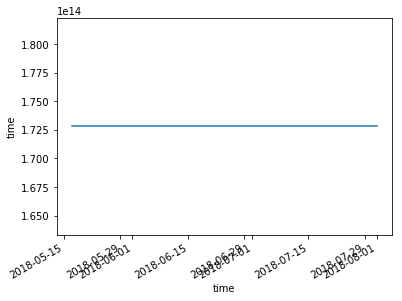

In [11]:
cube.time.diff(dim='time').plot.line()

In [12]:
cube.B04

<xarray.DataArray 'B04' (time: 40, lat: 2048, lon: 5632)>
dask.array<shape=(40, 2048, 5632), dtype=float32, chunksize=(1, 512, 512)>
Coordinates:
  * lat      (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon      (lon) float64 10.0 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time     (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
Attributes:
    sample_type:  FLOAT32
    units:        reflectance
    wavelength:   664.6
    bandwith:     31
    resolution:   10

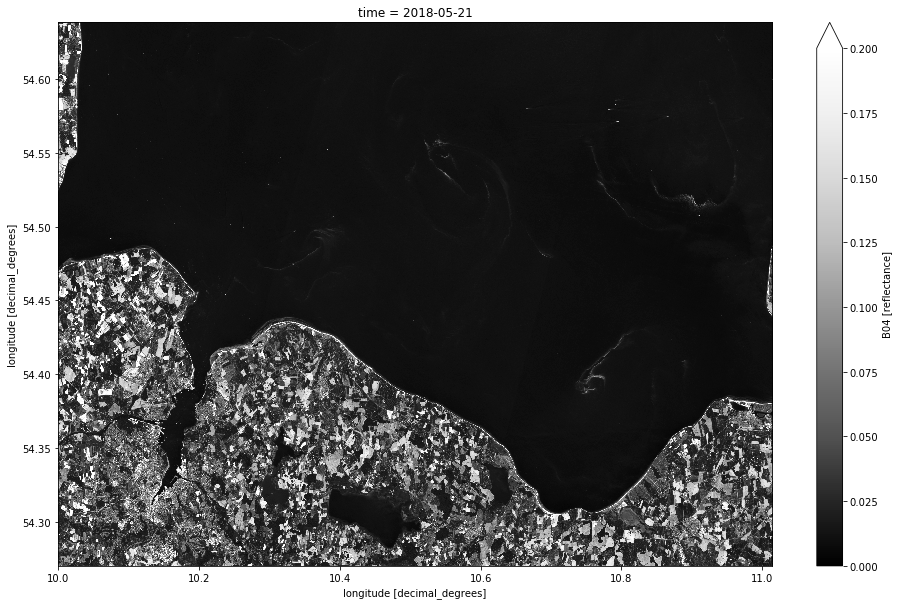

In [13]:
cube.B04.sel(time='2018-05-21 10:00:00', method='nearest').plot.imshow(vmin=0, vmax=0.2, cmap='Greys_r', figsize=(16, 10))

Now SentinelHub data requests have been made

In [14]:
request_collector.stats

Number of requests:,44
Request duration min:,482.54 ms
Request duration max:,1357.39 ms
Request duration median:,929.28 ms
Request duration mean:,927.17 ms
Request duration std:,243.70 ms


xcube mask sets also follow data cube structure

---
Example (2): Sentinel-2 L2A which only includes time stamps where there were valid observations for a given region. We use a `time_tolerance` of 30 minutes to decide whether scenes shall be combined:

In [15]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'B05', 'B06', 'B11', 'SCL', 'CLD'],
                         tile_size=[512, 512],
                         geometry=bbox,
                         spatial_res=spatial_res,
                         time_range=['2018-05-14', '2018-07-31'],                         
                         time_tolerance='30M')

In [16]:
cube = open_cube(cube_config)
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 2048, lon: 5632, time: 46)
Coordinates:
  * lat        (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon        (lon) float64 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time       (time) datetime64[ns] 2018-05-15T10:30:24 ... 2018-07-31T10:20:24
    time_bnds  (time, bnds) datetime64[ns] dask.array<shape=(46, 2), chunksize=(46, 2)>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<shape=(46, 2048, 5632), chunksize=(1, 512, 512)>
    B05        (time, lat, lon) float32 dask.array<shape=(46, 2048, 5632), chunksize=(1, 512, 512)>
    B06        (time, lat, lon) float32 dask.array<shape=(46, 2048, 5632), chunksize=(1, 512, 512)>
    B11        (time, lat, lon) float32 dask.array<shape=(46, 2048, 5632), chunksize=(1, 512, 512)>
    CLD        (time, lat, lon) uint8 dask.array<shape=(46, 2048, 5632), chunksize=(1, 512, 512)>
    SCL        (time, lat, lon) uin

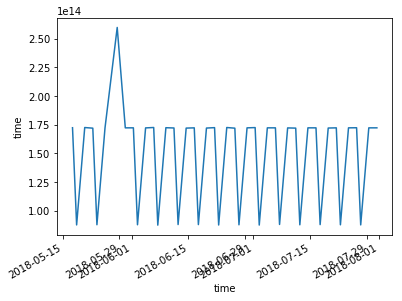

In [17]:
cube.time.diff(dim='time').plot.line()

---
Example (3): Using projected coordinates, setting the `crs` parameter to `'http://www.opengis.net/def/crs/EPSG/0/3857'` (EPSG:3857), that is Pseude-Mercato using a WGS-84 Ellisoid. Note that the spatial coordinates now switched from `lon`, `lat` to `x`, `y`. For other CRSes, refer to https://docs.sentinel-hub.com/api/latest/#/API/crs.

We need to provide the `bbox` and `spatial_res` parameters in EPSG:3857 units (meters) now, Ljubljana area: 

In [18]:
x1 = 1545577  # meters
y1 = 5761986  # meters
x2 = 1705367  # meters
y2 = 5857046  # meters

bbox = x1, y1, x2, y2

spatial_res = (x2 - x1) / 512  # meters

Verify we are right:

In [19]:
geom = shapely.geometry.box(*bbox)

import functools
import pyproj
import shapely.ops

project = functools.partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:3857'),  # source coordinate system (Web Mercator)
    pyproj.Proj(init='epsg:4326'))  # destination coordinate system (WGS-84)

geom_wgs84 = shapely.ops.transform(project, geom)  # apply projection
IPython.display.GeoJSON(geom_wgs84.__geo_interface__)

<IPython.display.GeoJSON object>

In [20]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'B05', 'B06', 'B11', 'SCL', 'CLD'],
                         tile_size=[512, 512],
                         crs='http://www.opengis.net/def/crs/EPSG/0/3857',
                         geometry=bbox,
                         spatial_res=spatial_res,
                         time_range=['2018-05-01', '2018-05-10'],                         
                         time_period='1D')

In [21]:
cube = open_cube(cube_config)
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, time: 10, x: 512, y: 305)
Coordinates:
  * time       (time) datetime64[ns] 2018-05-01T12:00:00 ... 2018-05-10T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<shape=(10, 2), chunksize=(10, 2)>
  * x          (x) float64 1.546e+06 1.546e+06 1.546e+06 ... 1.705e+06 1.705e+06
  * y          (y) float64 5.857e+06 5.857e+06 5.856e+06 ... 5.762e+06 5.762e+06
Dimensions without coordinates: bnds
Data variables:
    B04        (time, y, x) float32 dask.array<shape=(10, 305, 512), chunksize=(1, 305, 512)>
    B05        (time, y, x) float32 dask.array<shape=(10, 305, 512), chunksize=(1, 305, 512)>
    B06        (time, y, x) float32 dask.array<shape=(10, 305, 512), chunksize=(1, 305, 512)>
    B11        (time, y, x) float32 dask.array<shape=(10, 305, 512), chunksize=(1, 305, 512)>
    CLD        (time, y, x) uint8 dask.array<shape=(10, 305, 512), chunksize=(1, 305, 512)>
    SCL        (time, y, x) uint8 dask.array<shape=(10, 305, 512), 

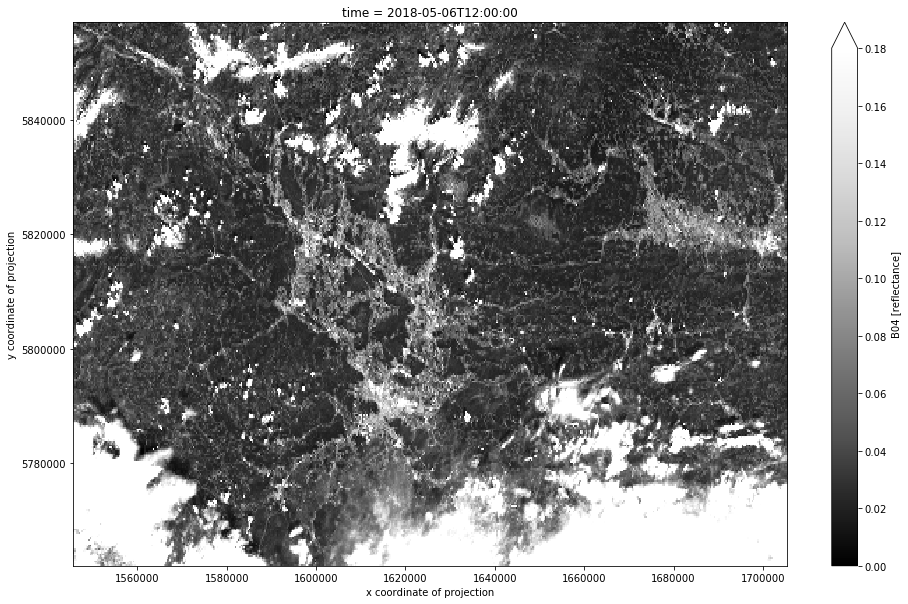

In [22]:
cube.B04.isel(time=5).plot.imshow(vmin=0, vmax=0.18, cmap='Greys_r', figsize=(16, 10))